## ERD

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import inspect
from scipy.stats import kurtosis, skew, norm
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


In [110]:
def read_dataset(file_path):
    df = pd.read_excel(file_path, engine='openpyxl')
    split_df = df.iloc[:, 0].str.split(',', expand=True)
    df = pd.concat([split_df, df.iloc[:, 1:]], axis=1)
    df.set_index(0, inplace=True)
    df.replace('', np.nan, inplace=True)
    float_columns = [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    df[float_columns] = df[float_columns].astype(float)
    df[2] = df[2].astype(int)
    df[3] = pd.to_datetime(df[3])
    if len(df.columns) == 16:
        df.columns = [i for i in range(15)] + ['target']
        df['target'] = df['target'].astype(float)
    else:
        df.columns = [i for i in range(15)]
    return df

train_df = read_dataset('Train.xlsm')
test_df = read_dataset('Test.xlsm')

/tmp/ipykernel_68505/3227723229.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat([split_df, df.iloc[:, 1:]], axis=1)
/tmp/ipykernel_68505/3227723229.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat([split_df, df.iloc[:, 1:]], axis=1)


##### Исключение из обучающей выборки наблюдений без таргета. Слабо заполненные наблюдения сохранены.

In [92]:
print(train_df[train_df['target'].isnull()])
train_df = train_df.dropna(subset=['target'])
train_df

            0  1                   2             3          4         5  \
0                                                                         
112  3.401852  1 2023-06-29 14:23:10  11749.246600  62.164723  2.340516   
347  4.483810  2 2023-07-29 17:30:00  16674.227024  61.720851  2.704736   

            6         7         8         9        10        11        12  \
0                                                                           
112  0.054909  7.432914  5.050278  0.001835  1.636205  57.28205  0.345821   
347  0.135478  7.747553  4.677701  0.002944  1.597872  57.38880  0.529372   

           13        14  target  
0                                
112  0.142329  1.538316     NaN  
347  0.204275  1.406888     NaN  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,target
0,,,,,,,,,,,,,,,,
0,3.750398,5,2023-06-15 03:30:00,12903.833250,64.505981,2.429055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.623
1,4.005138,5,2023-06-15 05:30:00,16171.536150,66.194287,2.481289,0.064445,7.014456,4.593825,0.001492,1.421696,63.55895,0.231434,0.097160,NaN,0.749
2,1.138600,5,2023-06-15 08:30:00,1733.193000,28.557797,1.078523,0.060213,7.017953,5.006483,0.001901,1.424601,53.58850,0.287297,0.095316,NaN,0.567
3,1.616377,4,2023-06-16 00:30:00,8358.641357,55.669162,1.387313,0.067553,7.358407,4.699417,0.001742,1.522439,56.76965,0.297938,0.104719,NaN,0.868
4,3.858570,3,2023-06-16 03:30:00,13771.152234,64.979572,2.402651,0.068745,7.511205,4.730615,0.002402,1.406540,58.54170,0.369762,0.115043,NaN,0.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,1.541226,5,2023-09-02 05:30:00,16832.363058,59.738111,1.315700,0.035728,3.889718,5.927809,0.007788,1.352219,56.53480,0.026602,0.064896,1.103390,0.539
611,1.633076,1,2023-09-02 08:30:00,1638.324702,62.146119,1.387070,0.032118,3.888994,6.398580,0.001320,1.269232,55.29650,0.114387,0.044616,1.070049,0.413
612,1.416566,4,2023-09-02 12:30:00,8474.165994,60.084859,1.185423,0.036856,3.837705,5.761320,0.001320,1.391910,55.76620,0.175571,0.037610,1.083395,0.462


##### Анализ структуры датасета: типы данных, пропуски и дубликаты

In [93]:
train_df[train_df.duplicated(subset=[2], keep=False)].index

Index([], dtype='object', name=0)

In [94]:
pd.DataFrame({
    "Dtype": train_df.dtypes,
    "Null Count": train_df.isnull().sum(),
    "Unique Count": [train_df[col].nunique() for col in train_df.columns]
})

,Dtype,Null Count,Unique Count
0,float64,0,613
1,int64,0,5
2,datetime64[ns],0,613
3,float64,0,561
4,float64,0,582
5,float64,0,566
6,float64,18,592
7,float64,18,592
8,float64,18,592
9,float64,3,174


In [95]:
pd.DataFrame({
    "Dtype": test_df.dtypes,
    "Null Count": test_df.isnull().sum(),
    "Unique Count": [test_df[col].nunique() for col in test_df.columns]
})

,Dtype,Null Count,Unique Count
0,float64,0,154
1,int64,0,5
2,datetime64[ns],0,154
3,float64,0,138
4,float64,0,138
5,float64,0,129
6,float64,0,152
7,float64,0,152
8,float64,0,152
9,float64,0,95


##### Статистики по фичам

In [96]:
pd.DataFrame({
    "train_mean": train_df.mean(),
    "train_median": train_df.median(),
    "train_std": train_df.std(),
    "train_min": train_df.min(),
    "train_max": train_df.max(),
    "test_mean": list(test_df.mean()) + [0.0],
    "test_median": list(test_df.median()) + [0.0],
    "test_std": list(test_df.std()) + [0.0],
    "test_min": list(test_df.min()) + [0.0],
    "test_max": list(test_df.max()) + [0.0]
})

,train_mean,train_median,train_std,train_min,train_max,test_mean,test_median,test_std,test_min,test_max
0,4.693547,4.130857,17.936978,-0.013317,447.689555,4.55474,4.40241,1.070427,0.988758,7.458846
1,3.065253,3.0,1.420778,1,5,3.071429,3.0,1.451198,1,5
2,2023-07-24 20:57:59.608483072,2023-07-24 17:30:00,22 days 22:49:53.483469423,2023-06-15 03:30:00,2023-09-02 17:30:00,2023-09-12 16:23:45.974025984,2023-09-12 19:00:00,5 days 17:20:57.078743578,2023-09-02 20:30:00,2023-09-22 08:30:00
3,10019.525155,9273.297348,5744.816564,1271.441178,19130.656398,10465.979294,9810.099117,6116.989393,1540.8643,19587.526009
4,62.165115,62.407895,9.438233,-19.652586,214.510626,61.939569,62.093839,3.568592,29.857574,72.772606
5,2.585559,2.585597,2.287235,0.0,58.526671,2.729733,2.677427,0.452971,1.167249,3.792838
6,0.090115,0.080919,0.027064,0.023705,0.163735,0.088669,0.081122,0.034839,0.029844,0.161074
7,7.860769,7.981222,0.915198,3.581151,9.932541,7.475257,7.708084,1.101217,3.644153,9.234828
8,4.90034,4.850663,0.560613,3.250178,7.076745,5.247315,5.049736,0.822308,3.85433,7.285533
9,0.00278,0.00268,0.000768,0.00132,0.007788,0.002567,0.002402,0.00119,0.00132,0.01254


##### Распределение target

/tmp/ipykernel_68505/3225730940.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette="Blues")


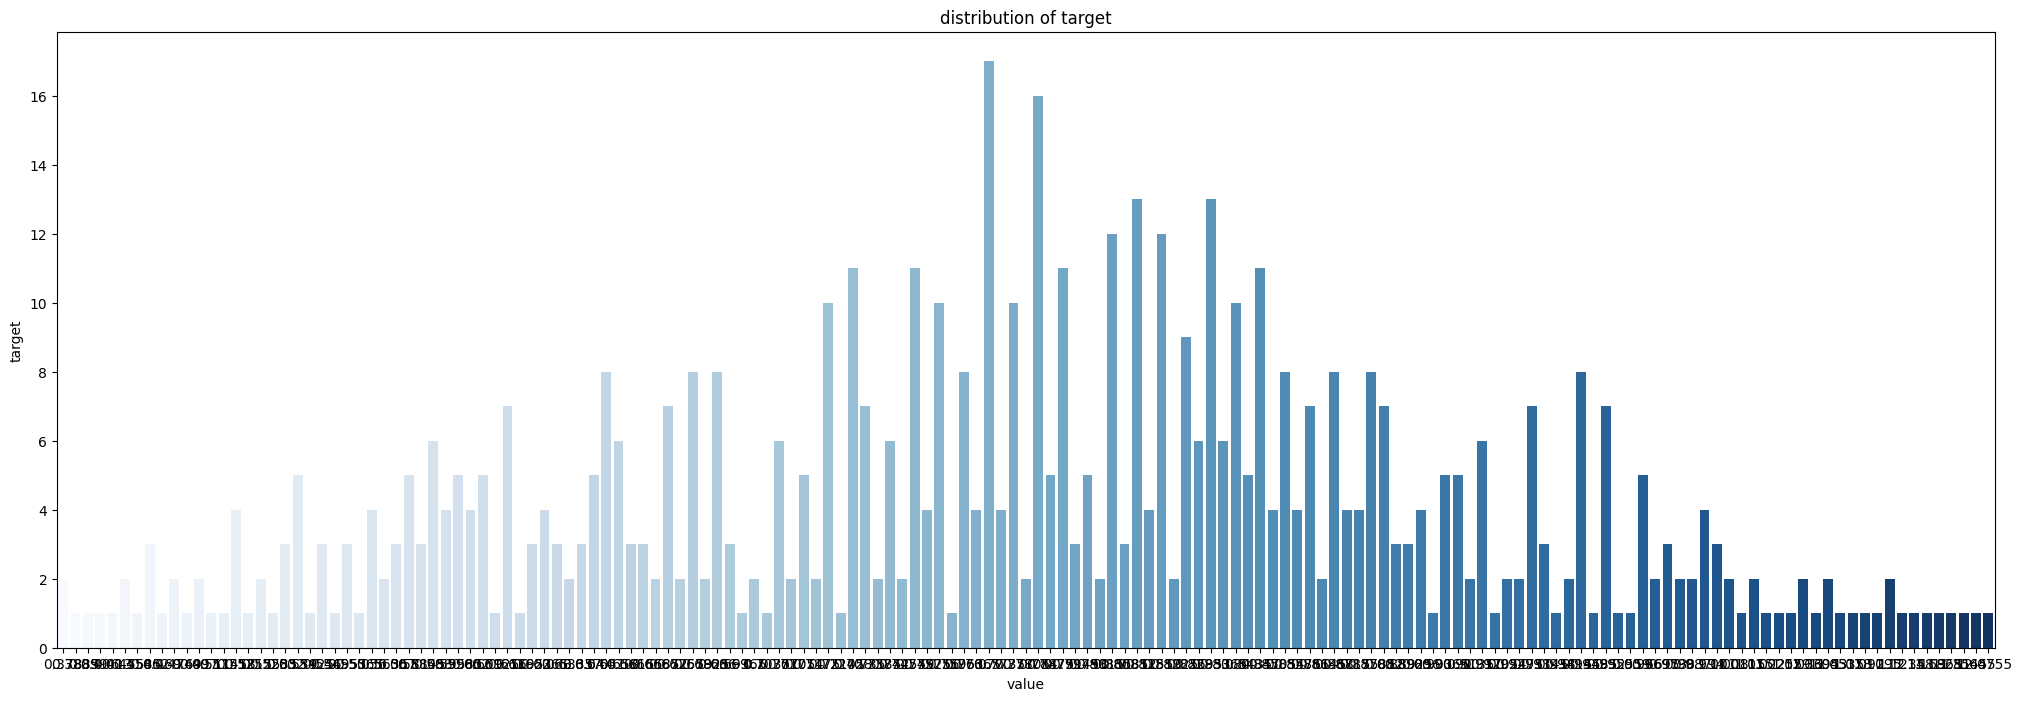

In [111]:
target_counts = train_df['target'].value_counts()
ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette="Blues")
plt.title("distribution of target")
plt.xlabel("value")
plt.ylabel("target")
plt.show()
plt.close()

##### Гистограммы KDE для признаков

In [98]:
def plot_kde_distributions(df, numeric_columns):
    summary_data = []
    for column in numeric_columns:
        data = df[column].dropna()

        plt.figure(figsize=(10, 6))
        ax = sns.histplot(
            data,
            kde=True,
            bins=30,
            edgecolor="black",
            color="royalblue",
            alpha=0.8,
            linewidth=1.2
        )
        kde_color = "darkorange"
        sns.kdeplot(data, color=kde_color, linewidth=2, label="KDE (плотность)")

        plt.title(f"Гистограмма и KDE для признака: {column}", fontsize=14, fontweight="bold")
        plt.xlabel(column, fontsize=12)
        plt.ylabel("Плотность / Частота", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        median = data.median()
        mean = data.mean()
        std_dev = data.std()
        plt.axvline(median, color="red", linestyle="--", linewidth=2, label=f"Медиана: {median:.2f}")
        plt.axvline(mean, color="blue", linestyle="-.", linewidth=2, label=f"Среднее: {mean:.2f}")
        percentiles = [0.25, 0.75, 0.99]
        percentile_values = data.quantile(percentiles)
        perc_colors = ["green", "purple", "brown"] 
        for perc, value, color in zip(percentiles, percentile_values, perc_colors):
            plt.axvline(value, color=color, linestyle=":", linewidth=2, label=f"{int(perc * 100)}-й перцентиль: {value:.2f}")
        try:
            x_range = np.linspace(data.min(), data.max(), 1000)
            ideal_pdf = norm.pdf(x_range, loc=mean, scale=std_dev)
            ideal_pdf_scaled = ideal_pdf * len(data) * (data.max() - data.min()) / 30 
            plt.plot(x_range, ideal_pdf_scaled, color="orange", linestyle="--", linewidth=2.5, label="Идеальное распределение")
        except Exception as e:
            print(f"Ошибка при построении идеального распределения для столбца {column}: {e}")
        try:
            kde = gaussian_kde(data)
            kde_values = kde(x_range)
            peak_x = x_range[np.argmax(kde_values)]
            peak_y = kde_values.max()

            plt.annotate(f"Пик: {peak_x:.2f}", xy=(peak_x, peak_y),
                        xytext=(peak_x + 0.5, peak_y + 0.1),
                        arrowprops=dict(facecolor='black', arrowstyle="->"),
                        fontsize=10)
        except np.linalg.LinAlgError:
            print(f"Не удалось построить KDE для столбца {column}, так как данные имеют низкую дисперсию.")
            peak_x = None
        plt.legend(fontsize=10)

        plt.show()
        plt.close()

        kurt = kurtosis(data)
        skewness = skew(data)

        if -0.5 <= skewness <= 0.5:
            distribution = "Нормальное"
        elif skewness > 0.5:
            distribution = "Смещенное вправо"
        elif skewness < -0.5:
            distribution = "Смещенное влево"
        else:
            distribution = "Неопределено"

        lower, upper = data.quantile(0.25), data.quantile(0.75)
        range_info = f"[{lower:.2f}, {upper:.2f}]"
        summary_data.append({
            "Признак": column,
            "Эксцесс": round(kurt, 2),
            "Асимметрия": round(skewness, 2),
            "Пик": round(peak_x, 2) if peak_x else None,
            "Среднее": round(mean, 2),
            "Медиана": round(median, 2),
            "25-й перцентиль": round(percentile_values[0.25], 2),
            "75-й перцентиль": round(percentile_values[0.75], 2),
            "99-й перцентиль": round(percentile_values[0.99], 2),
            "Распределение": range_info,
            "Вывод": distribution
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

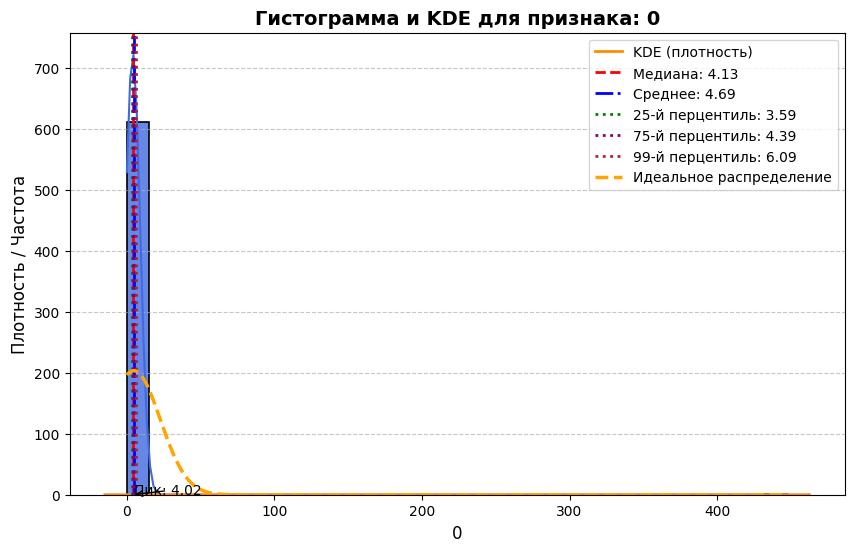

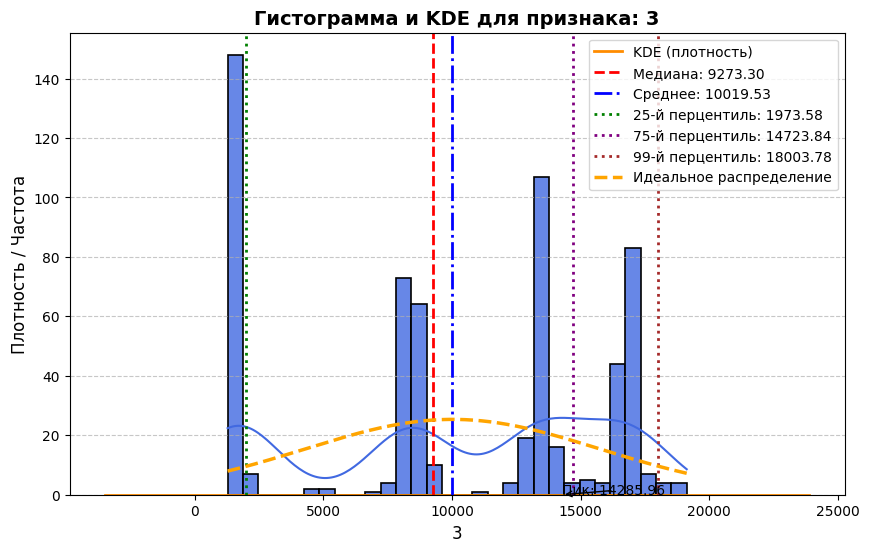

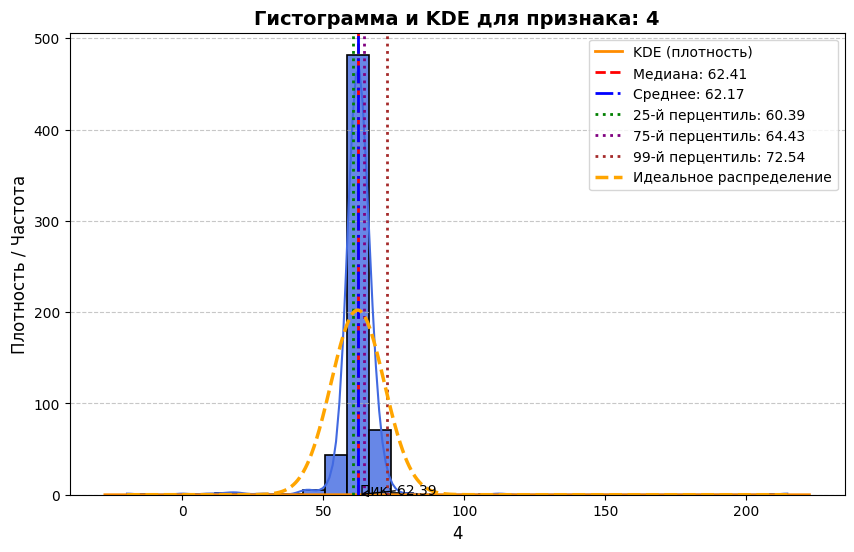

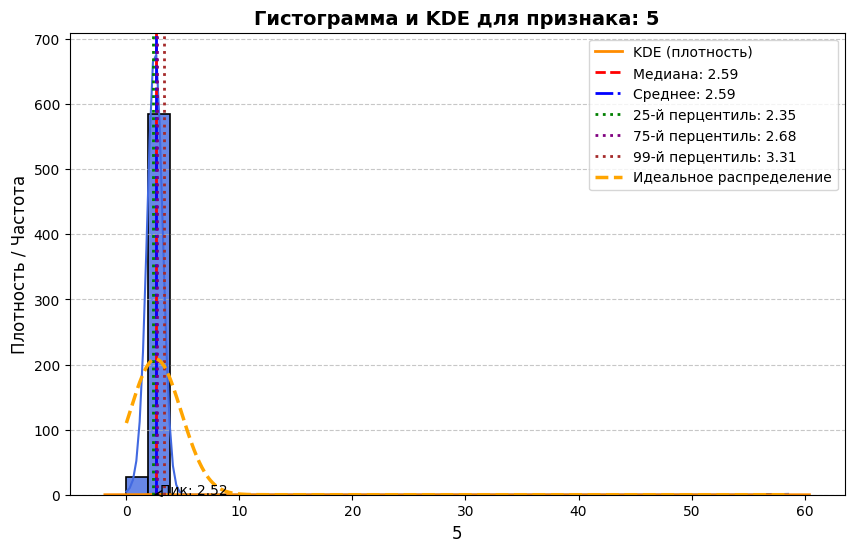

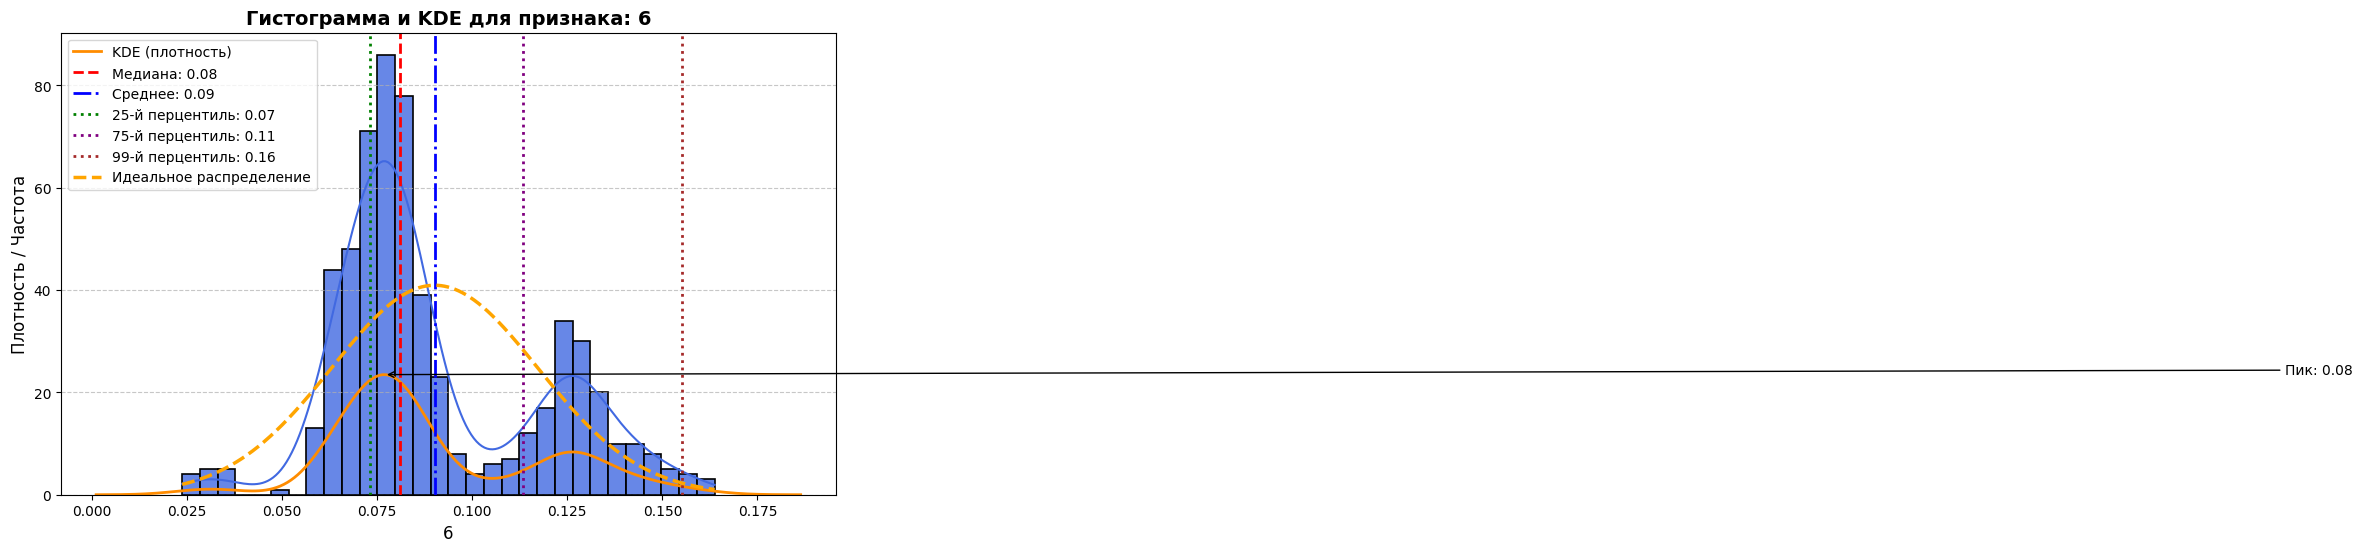

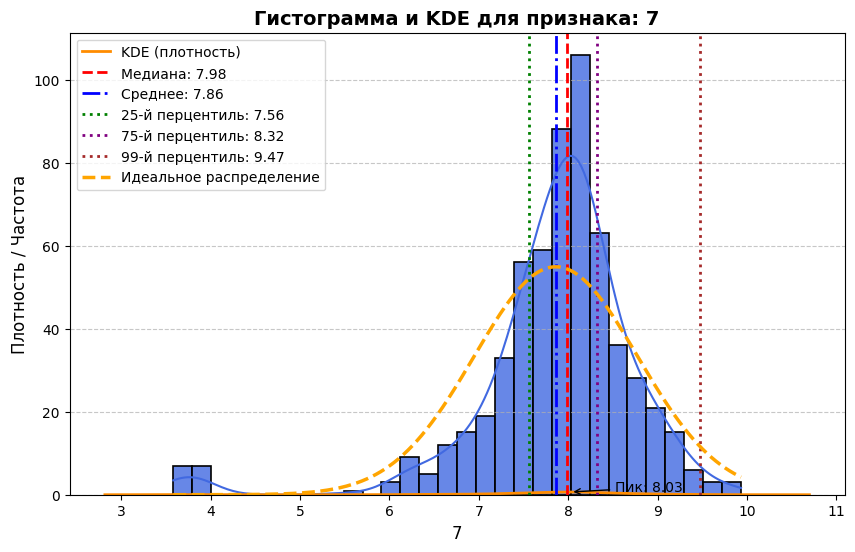

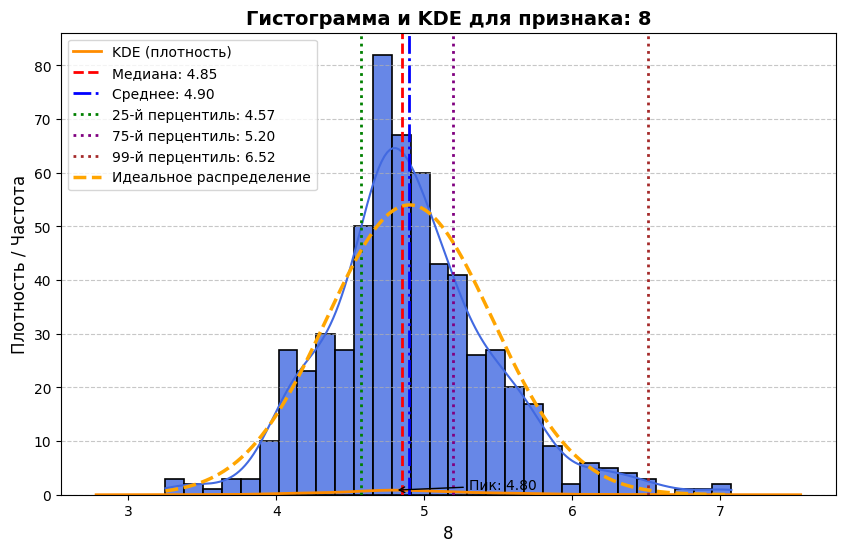

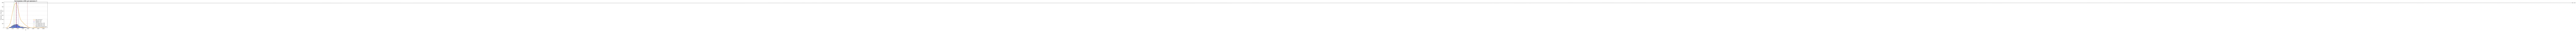

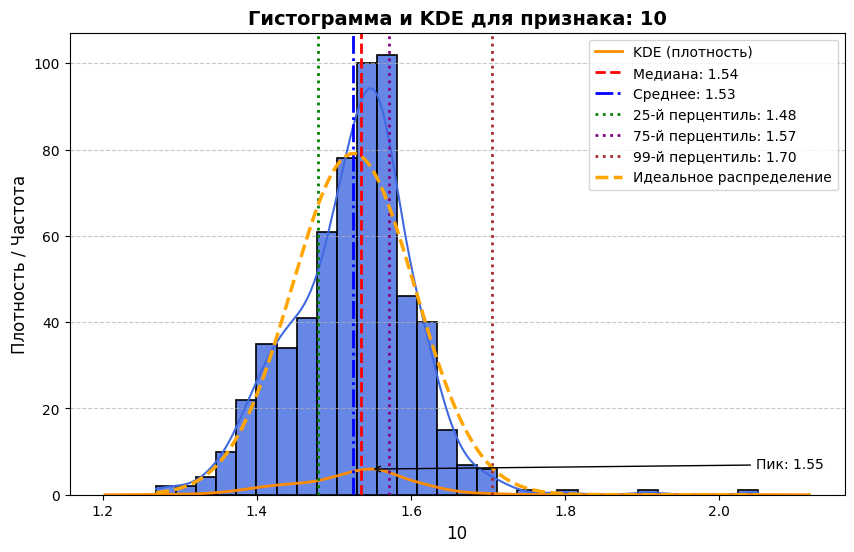

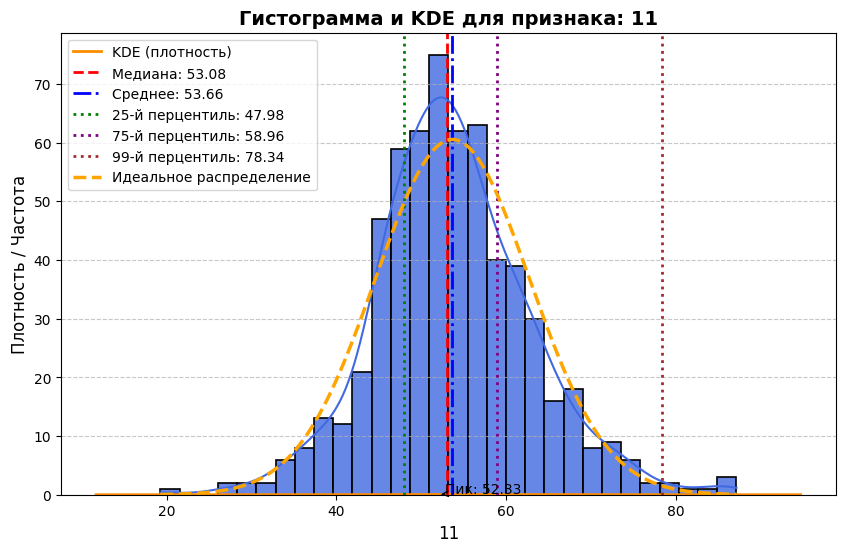

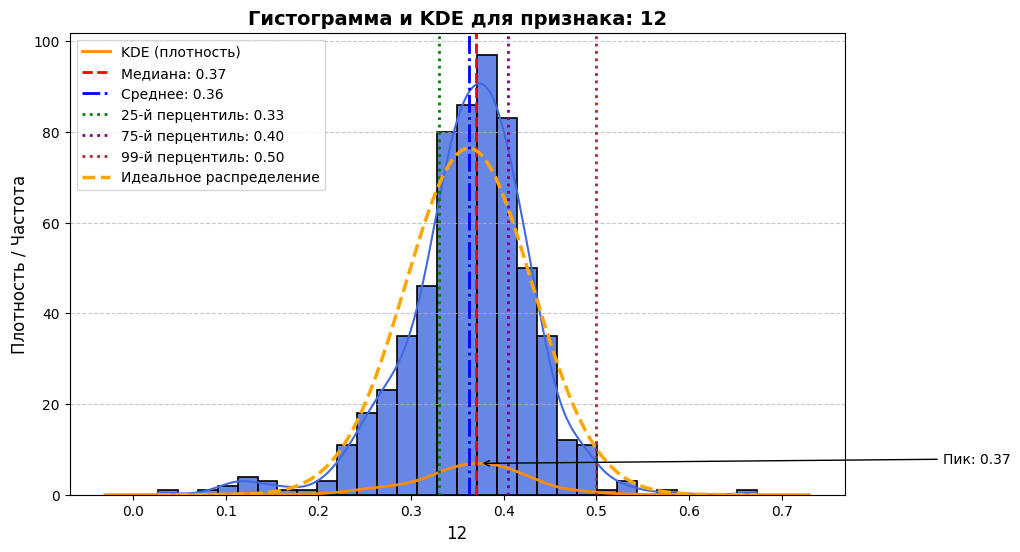

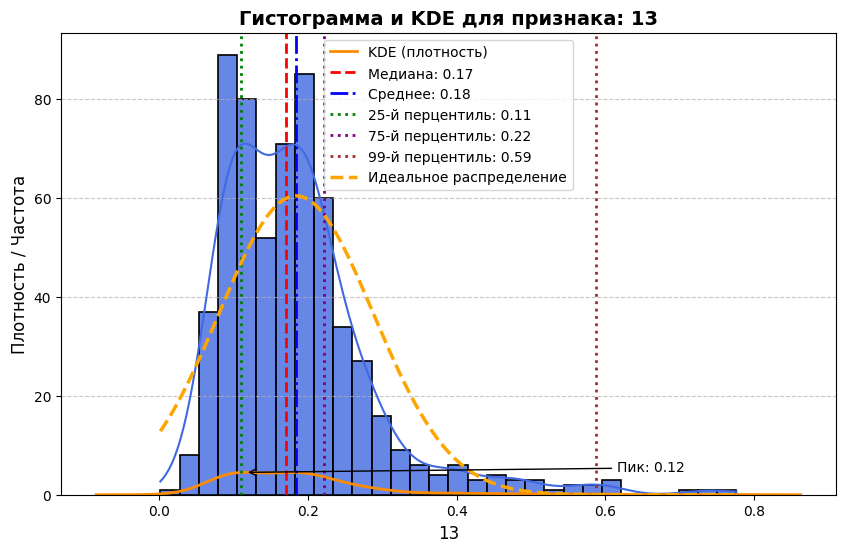

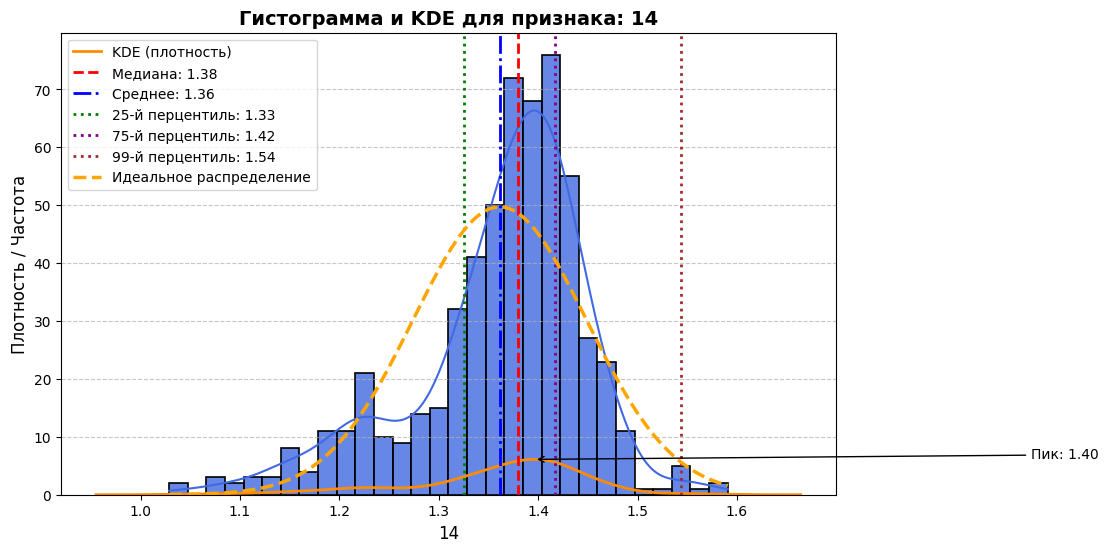

,Признак,Эксцесс,Асимметрия,Пик,Среднее,Медиана,25-й перцентиль,75-й перцентиль,99-й перцентиль,Распределение,Вывод
0,0,605.92,24.63,4.02,4.69,4.13,3.59,4.39,6.09,"[3.59, 4.39]",Смещенное вправо
1,3,-1.32,-0.30,14285.96,10019.53,9273.30,1973.58,14723.84,18003.78,"[1973.58, 14723.84]",Нормальное
2,4,126.21,4.69,62.39,62.17,62.41,60.39,64.43,72.54,"[60.39, 64.43]",Смещенное вправо
3,5,582.66,23.92,2.52,2.59,2.59,2.35,2.68,3.31,"[2.35, 2.68]",Смещенное вправо
4,6,-0.23,0.64,0.08,0.09,0.08,0.07,0.11,0.16,"[0.07, 0.11]",Смещенное вправо
5,7,7.58,-2.06,8.03,7.86,7.98,7.56,8.32,9.47,"[7.56, 8.32]",Смещенное влево
6,8,1.14,0.50,4.80,4.90,4.85,4.57,5.20,6.52,"[4.57, 5.20]",Смещенное вправо
7,9,3.42,1.14,0.00,0.00,0.00,0.00,0.00,0.00,"[0.00, 0.00]",Смещенное вправо
8,10,3.61,0.34,1.55,1.53,1.54,1.48,1.57,1.70,"[1.48, 1.57]",Нормальное
9,11,1.07,0.27,52.33,53.66,53.08,47.98,58.96,78.34,"[47.98, 58.96]",Нормальное


In [99]:
plot_kde_distributions(train_df, [0, 3, 4, 5 ,6 , 7, 8, 9, 10, 11, 12 ,13 ,14])

##### Детекция выбросов по фичам

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


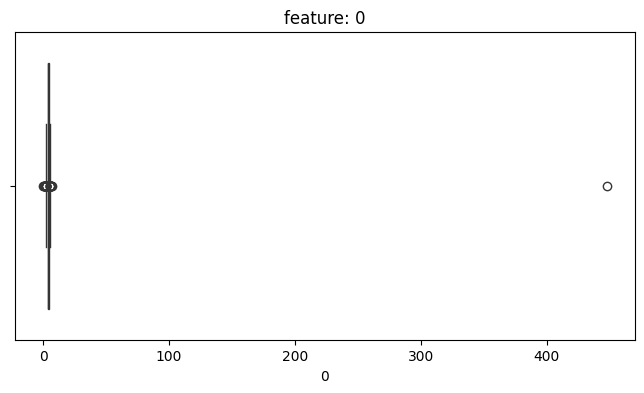

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


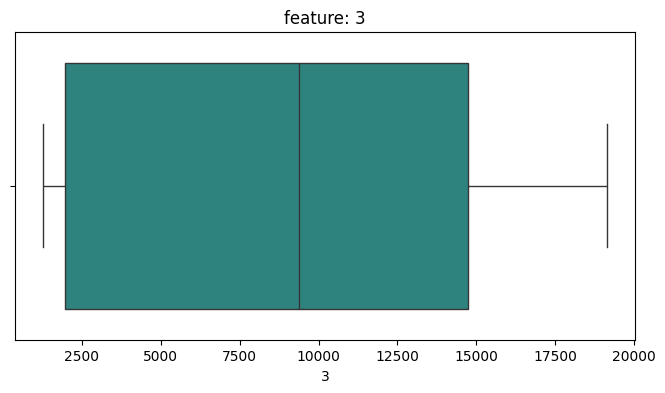

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


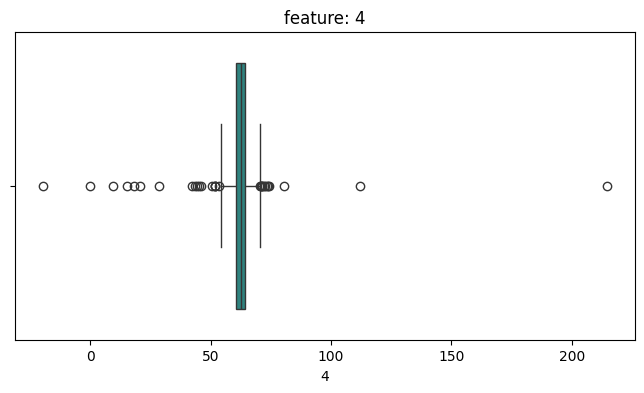

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


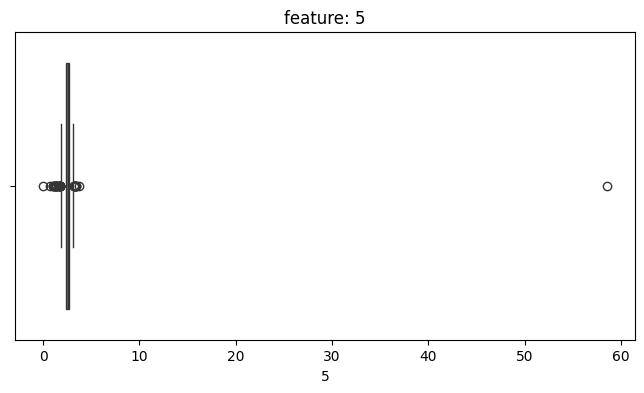

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


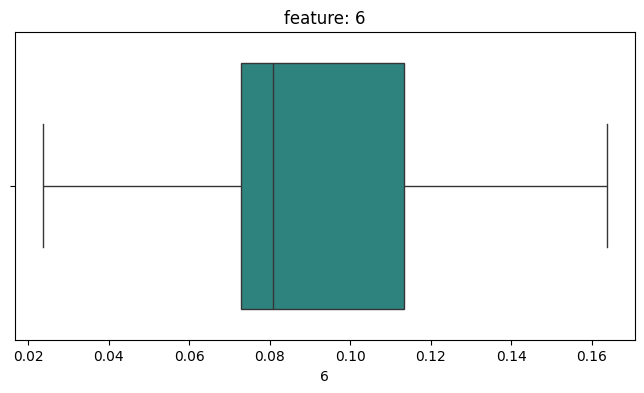

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


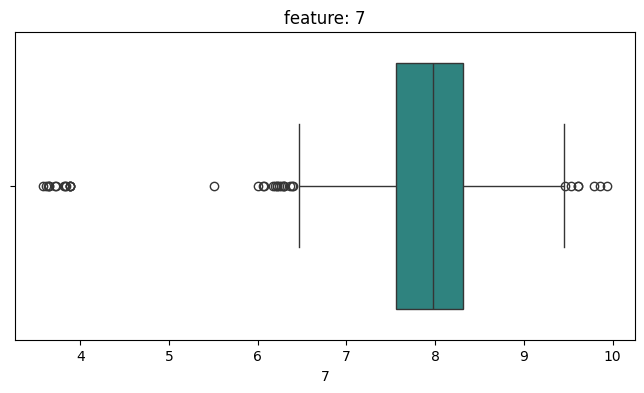

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


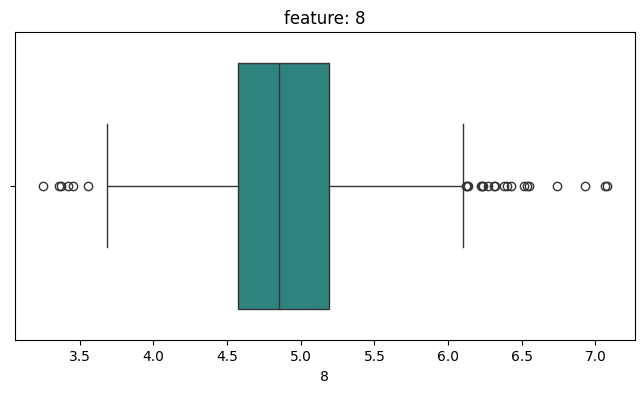

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


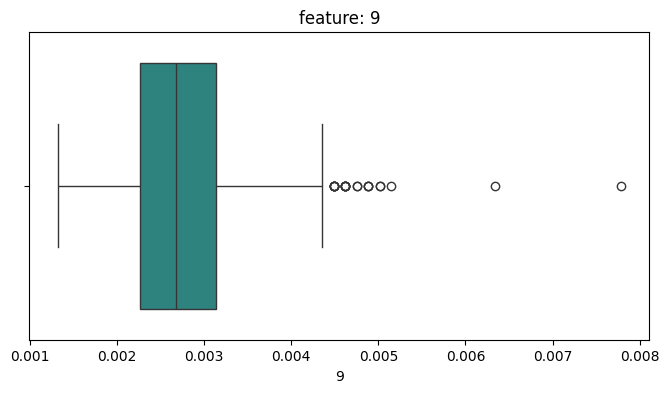

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


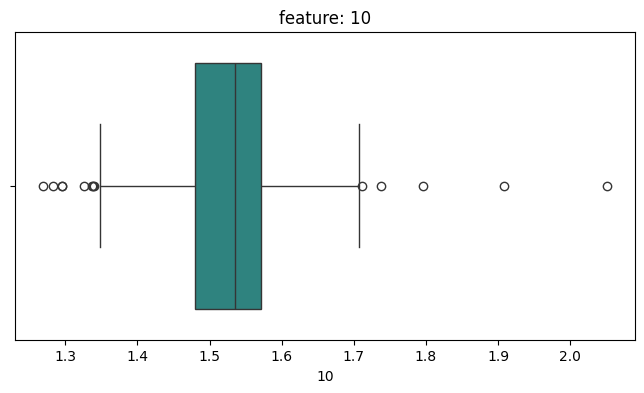

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


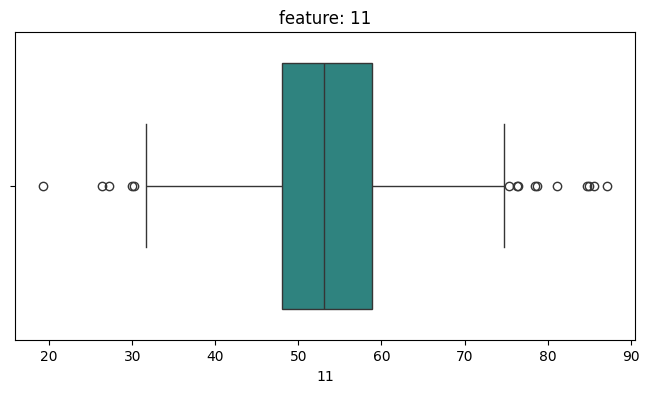

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


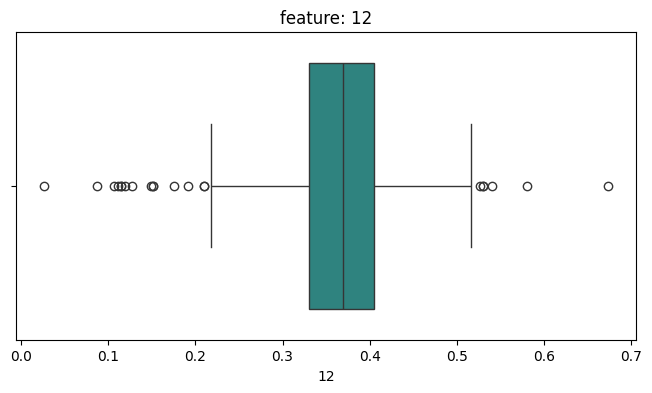

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


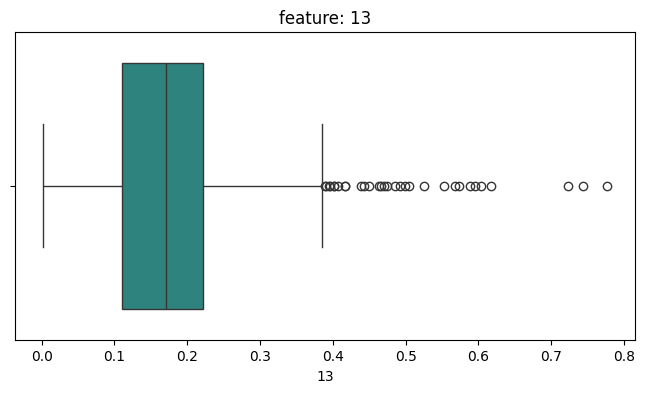

/tmp/ipykernel_68505/2455366234.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[column], palette="viridis")


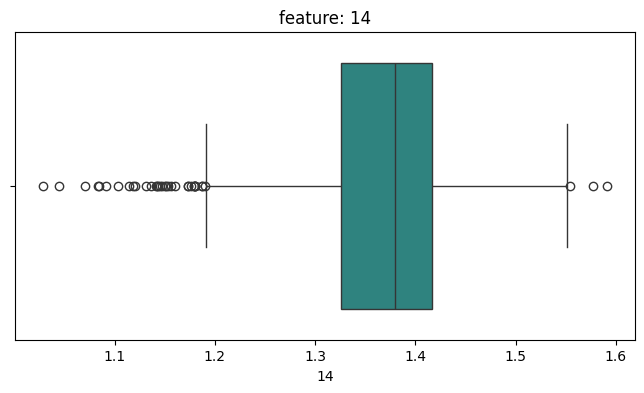

,Признак,Выбросы
0,0,"[1.1385995203826356, 1.6163769397940557, 447.6..."
1,3,[]
2,4,"[28.55779697624188, 80.43149840595105, 71.1854..."
3,5,"[1.0785226781857455, 1.3873125720876578, 58.52..."
4,6,[]
5,7,"[9.932540942090357, 9.854780186988897, 9.79020..."
6,8,"[3.3718277030391732, 3.250178285075948, 3.4548..."
7,9,"[0.004488000000000001, 0.004752, 0.00514800000..."
8,10,"[1.295946529069691, 1.2825198410373426, 1.3394..."
9,11,"[81.15135, 78.5253, 78.69609999999999, 84.7595..."


In [112]:
def detect_outliers_iqr(df, numeric_columns):
    outlier_summary = []

    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column].tolist()
        outlier_summary.append({
            'Признак': column,
            'Выбросы': outliers
        })
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[column], palette="viridis")
        plt.title(f"feature: {column}")
        plt.xlabel(column)
        plt.show()
        plt.close()

    outlier_summary_df = pd.DataFrame(outlier_summary)
    return outlier_summary_df

detect_outliers_iqr(train_df, [0, 3, 4, 5 ,6 , 7, 8, 9, 10, 11, 12 ,13 ,14])

##### Распределение по времени

/tmp/ipykernel_68505/1173175739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[datetime_column] = pd.to_datetime(df[datetime_column])
/tmp/ipykernel_68505/1173175739.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Месяц'] = df[datetime_column].dt.month
/tmp/ipykernel_68505/1173175739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

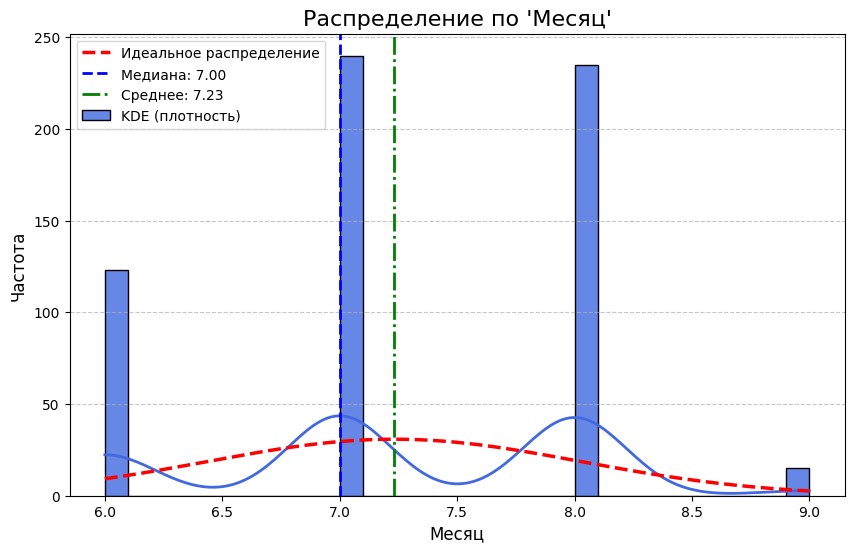

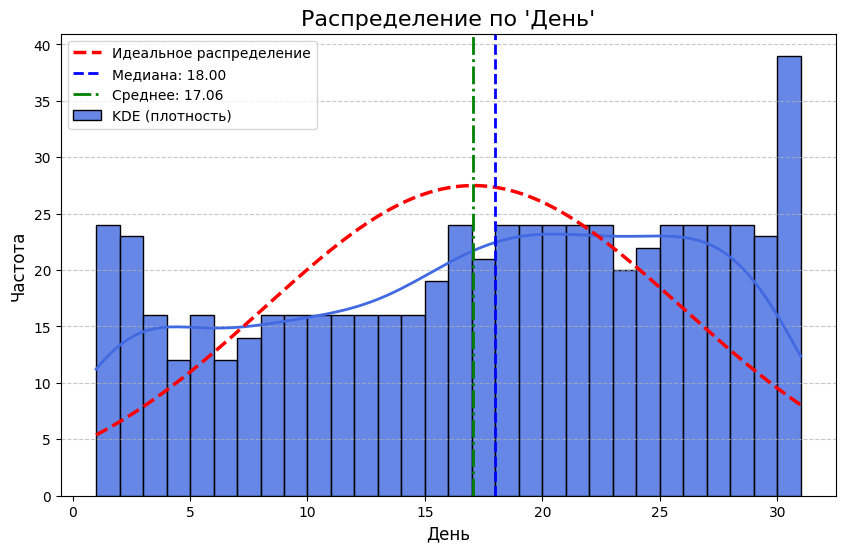

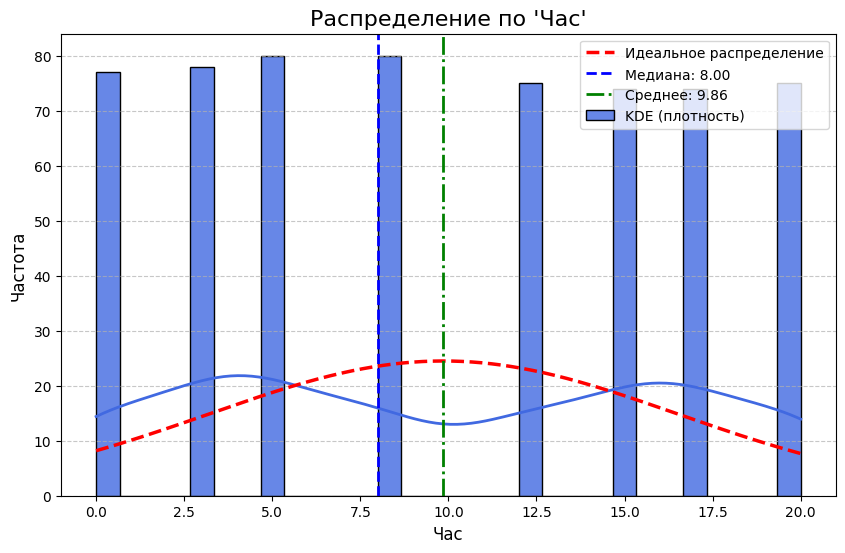

{'Месяц':    Месяц  Частота
 0      6      123
 1      7      240
 2      8      235
 3      9       15,
 'День':     День  Частота
 0      1       24
 1      2       23
 2      3       16
 3      4       12
 4      5       16
 5      6       12
 6      7       14
 7      8       16
 8      9       16
 9     10       16
 10    11       16
 11    12       16
 12    13       16
 13    14       16
 14    15       19
 15    16       24
 16    17       21
 17    18       24
 18    19       24
 19    20       24
 20    21       24
 21    22       24
 22    23       20
 23    24       22
 24    25       24
 25    26       24
 26    27       24
 27    28       24
 28    29       23
 29    30       24
 30    31       15,
 'Час':    Час  Частота
 0    0       77
 1    3       78
 2    5       80
 3    8       80
 4   12       75
 5   15       74
 6   17       74
 7   20       75}

In [108]:
def analyze_datetime_attributes(df, datetime_column):

    df[datetime_column] = pd.to_datetime(df[datetime_column])

    df['Месяц'] = df[datetime_column].dt.month
    df['День'] = df[datetime_column].dt.day
    df['Час'] = df[datetime_column].dt.hour

    attributes = ['Месяц', 'День', 'Час']
    summary_tables = {}

    for attr in attributes:
        data = df[attr].dropna()

        plt.figure(figsize=(10, 6))

        sns.histplot(
            data, 
            kde=True, 
            bins=30, 
            color='royalblue', 
            edgecolor='black', 
            alpha=0.8, 
            line_kws={"color": "orange", "linewidth": 2}, 
            label="KDE (плотность)"
        )

        mean = data.mean()
        std_dev = data.std()
        x_range = np.linspace(data.min(), data.max(), 1000)
        ideal_pdf = norm.pdf(x_range, loc=mean, scale=std_dev)
        ideal_pdf_scaled = ideal_pdf * len(data) * (data.max() - data.min()) / 30

        plt.plot(
            x_range, 
            ideal_pdf_scaled, 
            color="red", 
            linestyle="--", 
            linewidth=2.5, 
            label="Идеальное распределение"
        )

        median = data.median()
        plt.axvline(median, color="blue", linestyle="--", linewidth=2, label=f"Медиана: {median:.2f}")
        plt.axvline(mean, color="green", linestyle="-.", linewidth=2, label=f"Среднее: {mean:.2f}")

        plt.title(f"Распределение по '{attr}'", fontsize=16)
        plt.xlabel(attr, fontsize=12)
        plt.ylabel("Частота", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.legend(fontsize=10)
        plt.show()

        summary_table = data.value_counts().sort_index().reset_index()
        summary_table.columns = [attr, 'Частота']
        summary_tables[attr] = summary_table

    return summary_tables

analyze_datetime_attributes(train_df, 2)

##### Декомпозиция временного ряда

/tmp/ipykernel_68505/1932374607.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = pd.to_datetime(train_df[2])


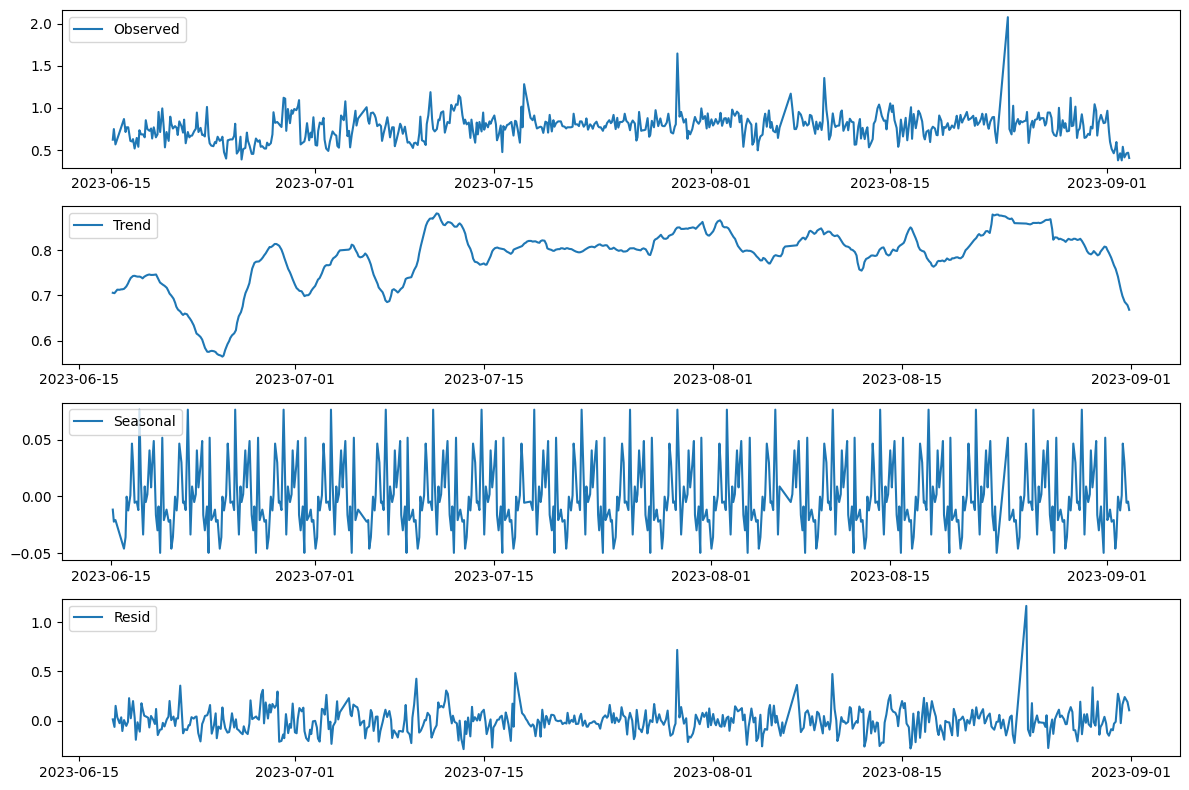

                     decomposition.observed  decomposition.trend  \
date                                                               
2023-06-15 03:30:00                   0.623                  NaN   
2023-06-15 05:30:00                   0.749                  NaN   
2023-06-15 08:30:00                   0.567                  NaN   
2023-06-16 00:30:00                   0.868                  NaN   
2023-06-16 03:30:00                   0.714                  NaN   
...                                     ...                  ...   
2023-09-02 05:30:00                   0.539                  NaN   
2023-09-02 08:30:00                   0.413                  NaN   
2023-09-02 12:30:00                   0.462                  NaN   
2023-09-02 15:30:00                   0.469                  NaN   
2023-09-02 17:30:00                   0.406                  NaN   

                     decomposition.seasonal  decomposition.resid  
date                                            

In [ ]:

def decompose_time_series(train_df, target_column='target', period=30):
    train_df['date'] = pd.to_datetime(train_df[2])
    train_df.set_index('date', inplace=True)
    decomposition = seasonal_decompose(train_df[target_column], model='additive', period=period)
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Оbserved')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Resid')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
    print(pd.DataFrame({'decomposition.observed': decomposition.observed, 
           'decomposition.trend': decomposition.trend,
           'decomposition.seasonal': decomposition.seasonal,
           'decomposition.resid': decomposition.resid}))
    return decomposition

decompose_time_series(train_df)


##### По результатам теста Дики-Фуллера считаем ряд стационарным

In [ ]:
result = adfuller(train_df['target'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -4.4705015024136925
p-значение: 0.0002222350450736213
Критические значения:
  1%: -3.441204979288887
  5%: -2.86632910370007
  10%: -2.56932048425654
